In [1]:
#import packages
import pandas as pd
import numpy as np
import keras 
import tensorflow as tf
import copy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score

In [2]:
#import data
import_data = pd.read_csv('icml_face_data.csv')

In [3]:
#process raw data into training, validation and testing
training = copy.deepcopy(import_data[import_data[' Usage'] == 'Training'])
training.drop(columns = [' Usage'],inplace = True)
training.reset_index(drop = True,inplace = True)
validation = copy.deepcopy(import_data[import_data[' Usage'] == 'PrivateTest'])
validation.drop(columns = [' Usage'],inplace = True)
validation.reset_index(drop = True,inplace = True)
testing = copy.deepcopy(import_data[import_data[' Usage'] == 'PublicTest'])
testing.drop(columns = [' Usage'],inplace = True)
testing.reset_index(drop = True,inplace = True)

In [4]:
#define functions

#reshape data for models other than CNN and VGG
def reshape_data_general(raw_data):
    y = copy.deepcopy(raw_data['emotion'])
    data = raw_data.drop(columns = ['emotion'])
    x = []
    for i in range(data.shape[0]):
        sample = copy.deepcopy(data.loc[i,' pixels'])
        sample = sample.split(' ')
        sample = np.array(list(map(int, sample)))/255-1
        x.append(sample)
    x = np.array(x)
    return x,y
#reshape data for CNN and VGG
def reshape_data_CNN(raw_data):
    y = copy.deepcopy(raw_data['emotion'])
    data = raw_data.drop(columns = ['emotion'])
    x = []
    for i in range(data.shape[0]):
        sample = copy.deepcopy(data.loc[i,' pixels'])
        sample = sample.split(' ')
        sample = np.array(list(map(int, sample)))/255-1
        sample = sample.reshape((48,48,1))
        x.append(sample)
    x = np.array(x)
    y = y.to_frame()
    y = pd.get_dummies(y,columns = ['emotion'])
    return x,y
#generate sample images
def generate_image(pixels):
    plt.imshow(pixels)
    plt.show()
#generate training class weights used for fitting CNN and VGG
def get_class_weights(data):
    uniques = data.emotion.unique()
    dist_dict = {}
    for i in uniques:
        dist_dict[i] = data[data.emotion == i].shape[0]/data.shape[0]
    return dist_dict
#graph CNN and VGG model metrics
def metrics_grapher_CNN(history):
    length = int(len(history.history)/2)
    key_list = list(history.history.keys())
    for i in range(len(key_list)):
        if i==length:
            break
        plt.plot(history.history[key_list[i]])
        plt.plot(history.history[key_list[i+length]])
        plt.title('model '+key_list[i])
        plt.ylabel(key_list[i])
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()    
# print CNN and VGG model summary
def model_summary_CNN(model):
    model.summary()
    return None
#convert index labels into string for CNN and VGG
def convert_labels_CNN(ypred,ytrue,label_list):
    pred_indices = np.argmax(ypred,axis = 1)
    true_indices = np.argmax(ytrue,axis = 1)
    pred = []
    true = []
    for i in range(pred_indices.shape[0]):
        pred.append(label_list[pred_indices[i]])
        true.append(label_list[true_indices[i]])
    return pred,true
#convert index labels into string for other models
def convert_labels_general(ypred,ytrue,label_list):
    pred = []
    true = []
    for i in range(ypred.shape[0]):
        pred.append(label_list[ypred[i]])
        true.append(label_list[ytrue[i]])
    return pred,true
#draw confusion matrix
def draw_confusion(true,pred,label_list):
    cm = confusion_matrix(true,pred,labels = label_list)
    confusionMatrix = pd.DataFrame(cm,
                         index = label_list, 
                         columns = label_list)
    ax= plt.subplot()
    sns.heatmap(confusionMatrix, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    return None
#display statistics for CNN and VGG model
def describe_CNN(model,history,xtest,ytest,label_list,is_vgg16):
    metrics_grapher_CNN(history)
    model_summary_CNN(model)
    if is_vgg16:
        xtest = np.repeat(xtest, repeats=3, axis=3)
    ypred_CNN = model.predict(xtest)
    CNNpred,true = convert_labels_CNN(ypred_CNN,ytest.values,label_list)
    print(classification_report(true, CNNpred))
    draw_confusion(true,CNNpred,label_list)
    return None
#display statistics for other models
def describe_general(model,xtest,ytest,label_list):
    ypred = model.predict(xtest)
    pred,true = convert_labels_general(ypred,ytest.to_numpy(),label_list)
    print(classification_report(true, pred))
    draw_confusion(true,pred,label_list)
    return accuracy_score(pred,true)
#describe data
def describe_data(training,validation,testing,xtrain,label_list):
    print('train size: '+str(training.shape[0]))
    print('validation size: '+str(validation.shape[0]))
    print('test size: '+str(testing.shape[0]))
    training_label = []
    valid_label = []
    testing_label = []
    for i in range(training.shape[0]):
        training_label.append(label_list[training['emotion'][i]])
    for i in range(testing.shape[0]):
        testing_label.append(label_list[testing['emotion'][i]])
    for i in range(validation.shape[0]):
        valid_label.append(label_list[validation['emotion'][i]])
    print('training set class distribution: ')
    plt.hist(np.array(training_label),bins = 7)
    plt.show()
    print('testing set class distribution: ')
    plt.hist(np.array(testing_label),bins = 7)
    plt.show()
    print('validation set class distribution: ')
    plt.hist(np.array(valid_label),bins = 7)
    plt.show()
    for i in label_list:
        print(i)
        generate_image(xtrain[training_label.index(i)])
        plt.show()
    return None
#definte VGG model
def VGG16_model(xtrain,ytrain,xval,yval,class_weights,filter_num,filter_size,pooling_size,dropout_rate):
    xtrain_colored = np.repeat(xtrain, repeats=3, axis=3)
    xval_colored = np.repeat(xval, repeats=3, axis=3)
    base_model = VGG16(weights="imagenet", include_top=False, input_shape= (48, 48, 3))
    base_model.trainable = False
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile( 'adam',loss='categorical_crossentropy',metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,verbose = 1)
    history = model.fit(xtrain_colored, ytrain,validation_data=(xval_colored, yval),class_weight = class_weights,epochs=100,
                            batch_size=100, callbacks=[callback])
    return model,history
#define CNN model
#conv - pooling - conv- pooling- flatten - dense - dense
def CNN_model(xtrain,ytrain,xval,yval,class_weights,filter_num,filter_size,pooling_size,dropout_rate):
    model = Sequential()
    model.add(Conv2D(filters = filter_num, kernel_size =  filter_size, activation='relu',padding="same" ,
                     input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(filters = filter_num, kernel_size = filter_size,padding="same" , activation='relu'))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    model.compile( 'adam',loss='categorical_crossentropy',metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,verbose = 1)
    history = model.fit(xtrain, ytrain,validation_data=(xval, yval),class_weight = class_weights,epochs=100,
                        batch_size=100, callbacks=[callback])
    return model,history

In [5]:
#reshape data for CNN and VGG
xtrain,ytrain = reshape_data_CNN(training)
xval,yval = reshape_data_CNN(validation)
xtest,ytest = reshape_data_CNN(testing)

train size: 28709
validation size: 3589
test size: 3589
training set class distribution: 


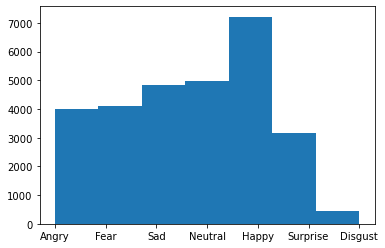

testing set class distribution: 


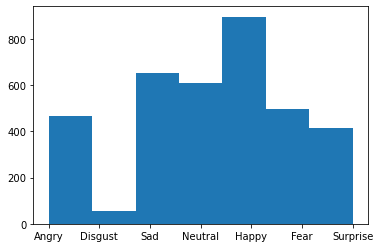

validation set class distribution: 


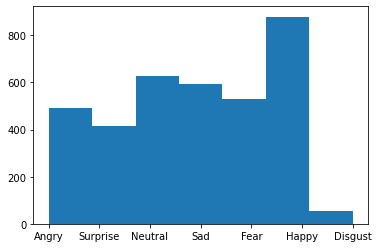

Angry


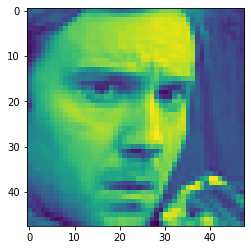

Disgust


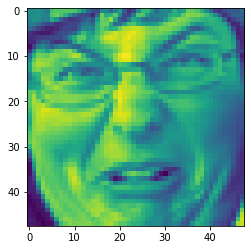

Fear


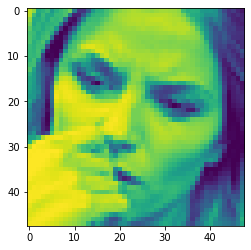

Happy


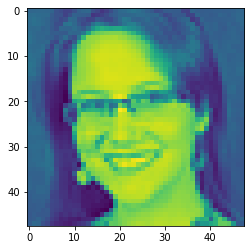

Sad


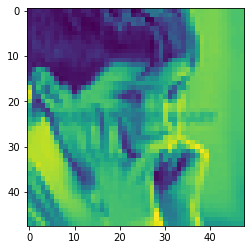

Surprise


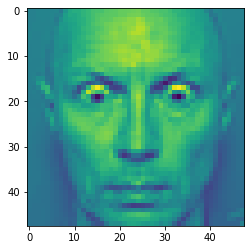

Neutral


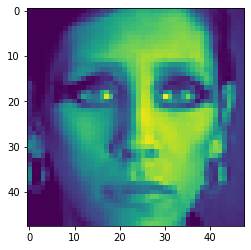

In [6]:
#show data info
label_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
describe_data(training,validation,testing,xtrain,label_list)

In [7]:
#define hyperparameters for CNN and VGG
class_weights  = get_class_weights(training)
filter_num = 64
filter_size = 3
pooling_size = 2
dropout_rate = 0.2
#train CNN model
model,history = CNN_model(xtrain= xtrain,ytrain= ytrain,xval = xval,yval = yval,class_weights = class_weights,
                      filter_num =filter_num,filter_size = filter_size 
                      ,pooling_size = pooling_size ,dropout_rate = dropout_rate)

Epoch 1/100
288/288 [==============================] - 43s 148ms/step - loss: 0.2628 - accuracy: 0.3318 - val_loss: 1.5170 - val_accuracy: 0.4433
Epoch 2/100
288/288 [==============================] - 45s 157ms/step - loss: 0.2262 - accuracy: 0.4417 - val_loss: 1.4533 - val_accuracy: 0.4578
Epoch 3/100
288/288 [==============================] - 45s 155ms/step - loss: 0.2081 - accuracy: 0.4895 - val_loss: 1.3855 - val_accuracy: 0.4742
Epoch 4/100
288/288 [==============================] - 42s 146ms/step - loss: 0.1960 - accuracy: 0.5187 - val_loss: 1.3428 - val_accuracy: 0.4990
Epoch 5/100
288/288 [==============================] - 42s 145ms/step - loss: 0.1840 - accuracy: 0.5539 - val_loss: 1.3584 - val_accuracy: 0.5174
Epoch 6/100
288/288 [==============================] - 43s 150ms/step - loss: 0.1724 - accuracy: 0.5836 - val_loss: 1.2862 - val_accuracy: 0.5274
Epoch 7/100
288/288 [==============================] - 46s 158ms/step - loss: 0.1614 - accuracy: 0.6062 - val_loss: 1.2766 -

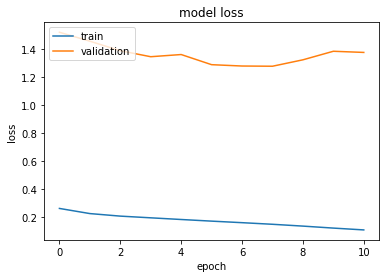

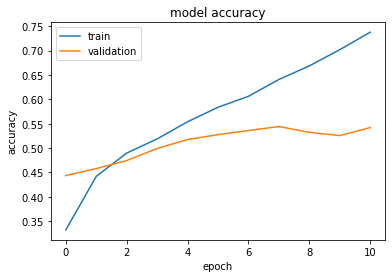

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0

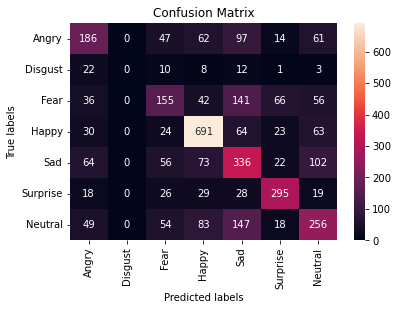

In [8]:
#describe CNN result
describe_CNN(model,history,xtest,ytest,label_list,False)

In [9]:
#train VGG model
VGGmodel,VGGhistory = VGG16_model(xtrain= xtrain,ytrain= ytrain,xval = xval,yval = yval,class_weights = class_weights,
                      filter_num =filter_num,filter_size = filter_size 
                      ,pooling_size = pooling_size ,dropout_rate = dropout_rate)

Epoch 1/100
288/288 [==============================] - 80s 277ms/step - loss: 0.2628 - accuracy: 0.3306 - val_loss: 1.6505 - val_accuracy: 0.3466
Epoch 2/100
288/288 [==============================] - 80s 278ms/step - loss: 0.2469 - accuracy: 0.3862 - val_loss: 1.6358 - val_accuracy: 0.3775
Epoch 3/100
288/288 [==============================] - 79s 276ms/step - loss: 0.2396 - accuracy: 0.4070 - val_loss: 1.5819 - val_accuracy: 0.4029
Epoch 4/100
288/288 [==============================] - 79s 275ms/step - loss: 0.2341 - accuracy: 0.4264 - val_loss: 1.5615 - val_accuracy: 0.4135
Epoch 5/100
288/288 [==============================] - 78s 271ms/step - loss: 0.2285 - accuracy: 0.4429 - val_loss: 1.5687 - val_accuracy: 0.4076
Epoch 6/100
288/288 [==============================] - 78s 270ms/step - loss: 0.2238 - accuracy: 0.4570 - val_loss: 1.5247 - val_accuracy: 0.4224
Epoch 7/100
288/288 [==============================] - 79s 273ms/step - loss: 0.2182 - accuracy: 0.4693 - val_loss: 1.5676 -

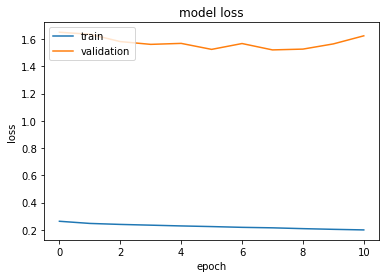

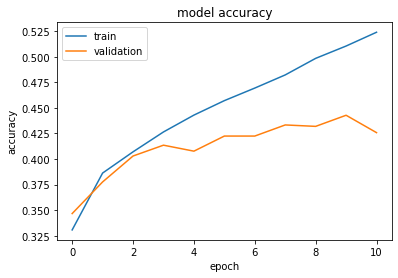

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 7)                 903       
                                                                 
Total params: 14,797,767
Trainable params: 83,079
Non-trainable params: 14,714,688
_________________________________________________________________
113/113 [============================

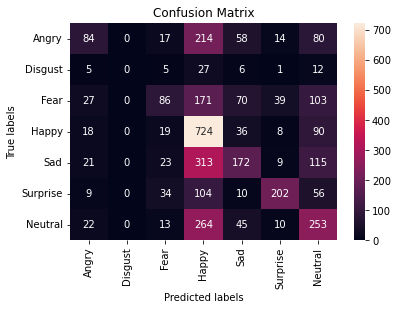

In [10]:
#descibe VGG result
describe_CNN(VGGmodel,VGGhistory,xtest,ytest,label_list,True)

In [11]:
#reshape data for other models
acc_list = []
model_list = []
xtrain_general,ytrain_general = reshape_data_general(training)
xval_general,yval_general = reshape_data_general(validation)
xtest_general,ytest_general = reshape_data_general(testing)

              precision    recall  f1-score   support

       Angry       0.21      0.15      0.17       467
     Disgust       0.00      0.00      0.00        56
        Fear       0.29      0.15      0.20       496
       Happy       0.46      0.68      0.55       895
     Neutral       0.33      0.36      0.35       607
         Sad       0.32      0.31      0.31       653
    Surprise       0.53      0.49      0.51       415

    accuracy                           0.38      3589
   macro avg       0.31      0.30      0.30      3589
weighted avg       0.36      0.38      0.36      3589



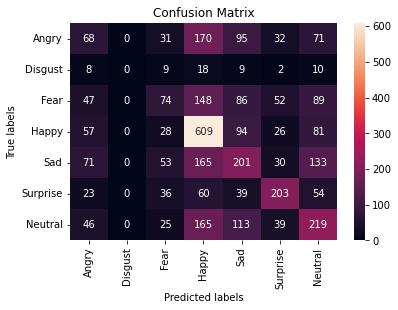

In [12]:
#train logistic regression 
clf = LogisticRegression().fit(xtrain_general,ytrain_general)
acc_list.append(describe_general(clf,xtest_general,ytest_general,label_list))
model_list.append('Logistic Regression')

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ......max_depth=5, n_estimators=10;, score=0.327 total time=   1.9s
[CV 2/4] END ......max_depth=5, n_estimators=10;, score=0.308 total time=   1.9s
[CV 3/4] END ......max_depth=5, n_estimators=10;, score=0.324 total time=   1.9s
[CV 4/4] END ......max_depth=5, n_estimators=10;, score=0.318 total time=   1.9s
[CV 1/4] END .....max_depth=5, n_estimators=100;, score=0.324 total time=  17.8s
[CV 2/4] END .....max_depth=5, n_estimators=100;, score=0.318 total time=  17.1s
[CV 3/4] END .....max_depth=5, n_estimators=100;, score=0.326 total time=  17.0s
[CV 4/4] END .....max_depth=5, n_estimators=100;, score=0.319 total time=  17.7s
[CV 1/4] END .....max_depth=10, n_estimators=10;, score=0.362 total time=   3.8s
[CV 2/4] END .....max_depth=10, n_estimators=10;, score=0.368 total time=   3.9s
[CV 3/4] END .....max_depth=10, n_estimators=10;, score=0.369 total time=   3.7s
[CV 4/4] END .....max_depth=10, n_estimators=10;,

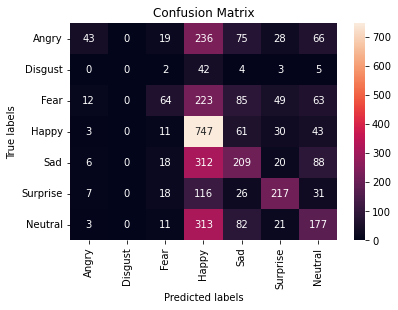

In [13]:
#random forest
clf = RandomForestClassifier()
params = {'max_depth':[5,10],
         'n_estimators': [10,100]}
grid = GridSearchCV(clf, param_grid=params, cv=4,verbose = 3).fit(xtrain_general, ytrain_general)
clf = grid.best_estimator_
print(clf)
acc_list.append(describe_general(clf,xtest_general,ytest_general,label_list))
model_list.append('Random Forest')

              precision    recall  f1-score   support

       Angry       0.16      0.04      0.07       467
     Disgust       0.03      0.21      0.06        56
        Fear       0.21      0.07      0.10       496
       Happy       0.39      0.16      0.23       895
     Neutral       0.24      0.16      0.19       607
         Sad       0.27      0.39      0.32       653
    Surprise       0.21      0.61      0.31       415

    accuracy                           0.23      3589
   macro avg       0.22      0.24      0.18      3589
weighted avg       0.26      0.23      0.21      3589



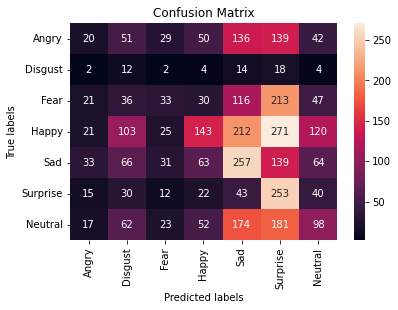

In [14]:
#NaiveBayes
clf = GaussianNB().fit(xtrain_general,ytrain_general)
acc_list.append(describe_general(clf,xtest_general,ytest_general,label_list))
model_list.append('Naive Bayes')

In [17]:
#print accuracy for models other than CNN and VGG
for i in range(len(model_list)):
    print(model_list[i]+' accuracy: '+str(acc_list[i]))

Logistic Regression accuracy: 0.3828364446921148
Random Forest accuracy: 0.40596266369462247
Naive Bayes accuracy: 0.22736138200055725
